In [1]:
%matplotlib notebook
from ABME import *
from agents import *

<IPython.core.display.Javascript object>


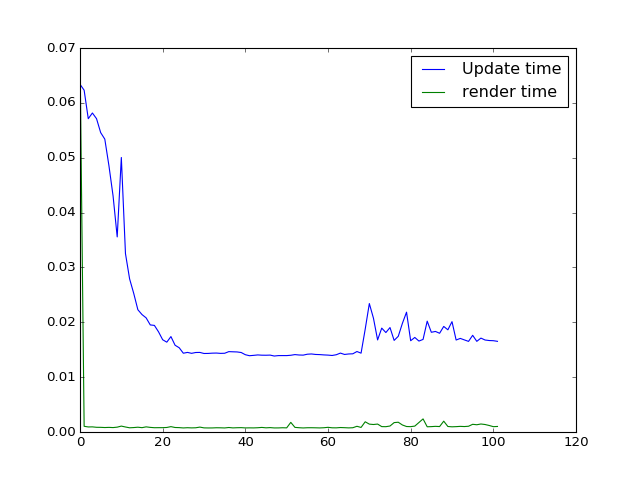

<IPython.core.display.Javascript object>


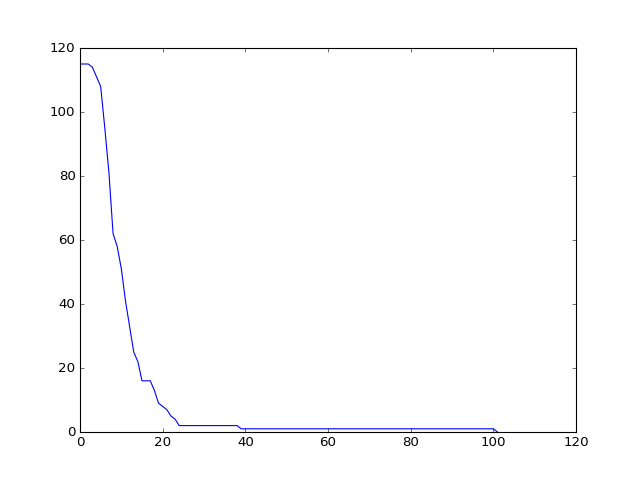

2.0942635536193848 0.0205319956237 0.0119946158631


In [2]:
#Setup objects
# First create a grid for the model and the model itself
g = Grid(50);
m = Model();
m.dead = []; #Create a list for the dead
#and add the grid to the model
m.set_grid(g);

# Create a visualizer and a tracker
vis = Visualizer(m);
tracker = Tracker(m);

# And track population using the default tracker
tracker.add_tracker('Population', lambda m: len(m.agents)); # lambda model: len(model.agents)

#Same as: def foo(model): return len(model.agents);
#         tracker.add_tracker('Population', foo);

#Later, tracker['Population'] can be used to get the population data

#Create 2 resources, these are automatically added to the grid [g]
r1 = Resource("Kerbonite", g);
r2 = Resource("Ebolite", g);

# Create a capacity function and regrowth function
cap=lambda x:np.round(4*np.exp(-(x**2)/(2*(0.05)**2))); #  x=distance from center(given in grow)
reg=lambda x:0.5; # Uniform growth of 0.5, x is ignored

# Set capacity
#    scale = true makes the distance from center from [0, 1]
#    Making a bigger map thus keeps the ratios of resources equal
#    scale = True is default
r1.set_capacity(20,20, fun=cap, scale=True);
r2.set_capacity(35,20, fun=cap, scale=True);

# grow to the given capacity (such that there are resources available in the first tick)
r1.grow(20,20, fun=cap);
r2.grow(35,20, fun=cap);


#add agents
for i in range(1000):
    a = EvolutionAgent();
    a.wealth_low = 10;
    a.wealth_high = 20;
    m.add_agent(a);
    #print(a);

# or add a single test agent
# a = SugerAgent();
# #Modify random variables before adding the agent
# # Modifying other variables which are randomly initialized, like vision, have no effect
# # before the add_agent call has been made as this call initializes these variables
# a.wealth_low = 10;
# a.wealth_high = 11;
# #Add the agent
# #    This call also initializes the agents values based on the _low _high
# #    From nowon, modifying things like wealth_low, has no effect
# m.add_agent(a, position=[35,35]); 
# #Set variables of this agent
# a.max_age = 20000;
# a.metabolism = 0.1;
# a.vision = 30;
    
# simulate
times = [];
times_render = [];
imgs = [];
#pl.figure(figsize=(10,10))
for i in range(1000):
    # Record time (not needed)
    t = time.time();
    
    # Core loop
    r1.grow(20,20,fun=cap);
    r2.grow(35,20, fun=cap);
    # following 3 calls is the same as m.step()
    m.step_move();
    m.step_act();
    m.track(); #Using all trackers, save data
    
    # Record time (not Needed)
    times.append(time.time() - t);
    
    #Render
    img = vis.plot_grid(new_fig=False);
    imgs.append([img]);
    
    #Record time (render) 
    times_render.append(time.time() - t);
    
    #Break if all agents have dieded
    if len(m.agents) == 0:
        break;


fig = pl.gcf();
vis.animate_axis_array(imgs, fig, fps=10, clear_output=True);

#plot performance information
pl.figure();
pl.plot(times);
pl.plot(np.array(times_render)-times);
pl.legend(['Update time', 'render time'])

#plot population
pl.figure();
pl.plot(tracker['Population']);
print(sum(times),np.mean(times), np.std(times));

for agent in m.agents:
    print(agent);

In [3]:
np.random.rand(5)

array([ 0.53888574,  0.94662455,  0.62782449,  0.6481104 ,  0.33542426])